In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

This Jupyter notebook will be the Machine learning part of the project. We will import the clean data and inspect it again to check which columns will help us build our machine learning model. This will include preprocessing the data, encoding categorical values, scaling numerical ones and using them for clustering using k-means.

## 1.1 Load and inspect the data

In [59]:
# Load the dataset
df = pd.read_csv('../data/cleaned_data/student_social_media_addiction_cleaned.csv')

In [60]:
# Inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   new_student_id                702 non-null    object 
 1   age                           702 non-null    int64  
 2   gender                        702 non-null    object 
 3   relationship_status           702 non-null    object 
 4   academic_level                702 non-null    object 
 5   country                       702 non-null    object 
 6   continents                    702 non-null    object 
 7   most_used_platform            702 non-null    object 
 8   average_daily_usage_minutes   702 non-null    float64
 9   average_daily_use_by_hour     702 non-null    int64  
 10  sleep_per_night_minutes       702 non-null    float64
 11  sleep_hours_per_night         702 non-null    float64
 12  conflicts_over_social_media   702 non-null    int64  
 13  affec

In [61]:
# Check the columns and pick out which ones we will use going forward
df.columns

Index(['new_student_id', 'age', 'gender', 'relationship_status',
       'academic_level', 'country', 'continents', 'most_used_platform',
       'average_daily_usage_minutes', 'average_daily_use_by_hour',
       'sleep_per_night_minutes', 'sleep_hours_per_night',
       'conflicts_over_social_media', 'affects_academic_performance',
       'addicted_score', 'mental_health_score'],
      dtype='object')

We will using the following columns:
- gender  
- relationship_status  
- academic_level  
- continents  
- average_daily_usage_minutes  
- sleep_per_night_minutes  
- conflicts_over_social_media  
- affects_academic_performance  
- addicted_score  
- mental_health_score
- most used platform


In [62]:
# Create a copy of the dataset to be used specifically for machine learning
df_ml = df.copy()

In [63]:
# Drop unnecessary columns
df_ml = df.drop(columns=['new_student_id', 'age', 'country', 'average_daily_use_by_hour', 'sleep_hours_per_night'])

In [64]:
# Check required columns are all there
df_ml.columns

Index(['gender', 'relationship_status', 'academic_level', 'continents',
       'most_used_platform', 'average_daily_usage_minutes',
       'sleep_per_night_minutes', 'conflicts_over_social_media',
       'affects_academic_performance', 'addicted_score',
       'mental_health_score'],
      dtype='object')

## 1.2 Encode categoricals

Although clustering does not require train/test splitting we will split the dataset up that way in line with the method learned in the LMS. We will then encode the categorical data and scale it, this is to prevent the larger values from dominating our ml tool. Scaling will transform each numerical feature so that it has a mean of 0 and std of 1 as well as the newly encoded categoricals.

In [ ]:
# Assign categorical and numeric columns to dfs

cat_cols = ['gender', 'relationship_status', 'academic_level', 'continents', 'affects_academic_performance']
num_cols = ['average_daily_usage_minutes', 'sleep_per_night_minutes', 'conflicts_over_social_media',
            'addicted_score', 'mental_health_score']

preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(drop='first'), cat_cols),
    ('numeric', StandardScaler(), num_cols)
])

# Fit on training data
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

## 1.4 Determine cluster amount

We will use the elbow method and silhouette scores to work out the optimal number of clear clusters for our dataset. There is an element of trial and error to this but by using both indicators hopefully the most accurate number can be determined.

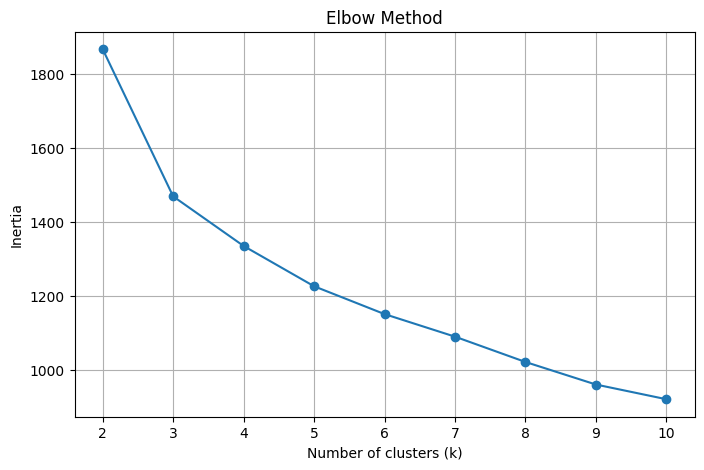

In [ ]:
# Run the elbow method test on dataset

sse = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_prepared)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, sse, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(True)
plt.savefig('../images/elbow_method.png')
plt.show()

The chart above indicates the the number of clusters required could be 3 looking at the bend in the line being close to the inside of an elbow. The silhouette score (below) will also help us decide how many clusters to use. The silhouette score measures cluster separation. The higher the values will result in better defined clusters.

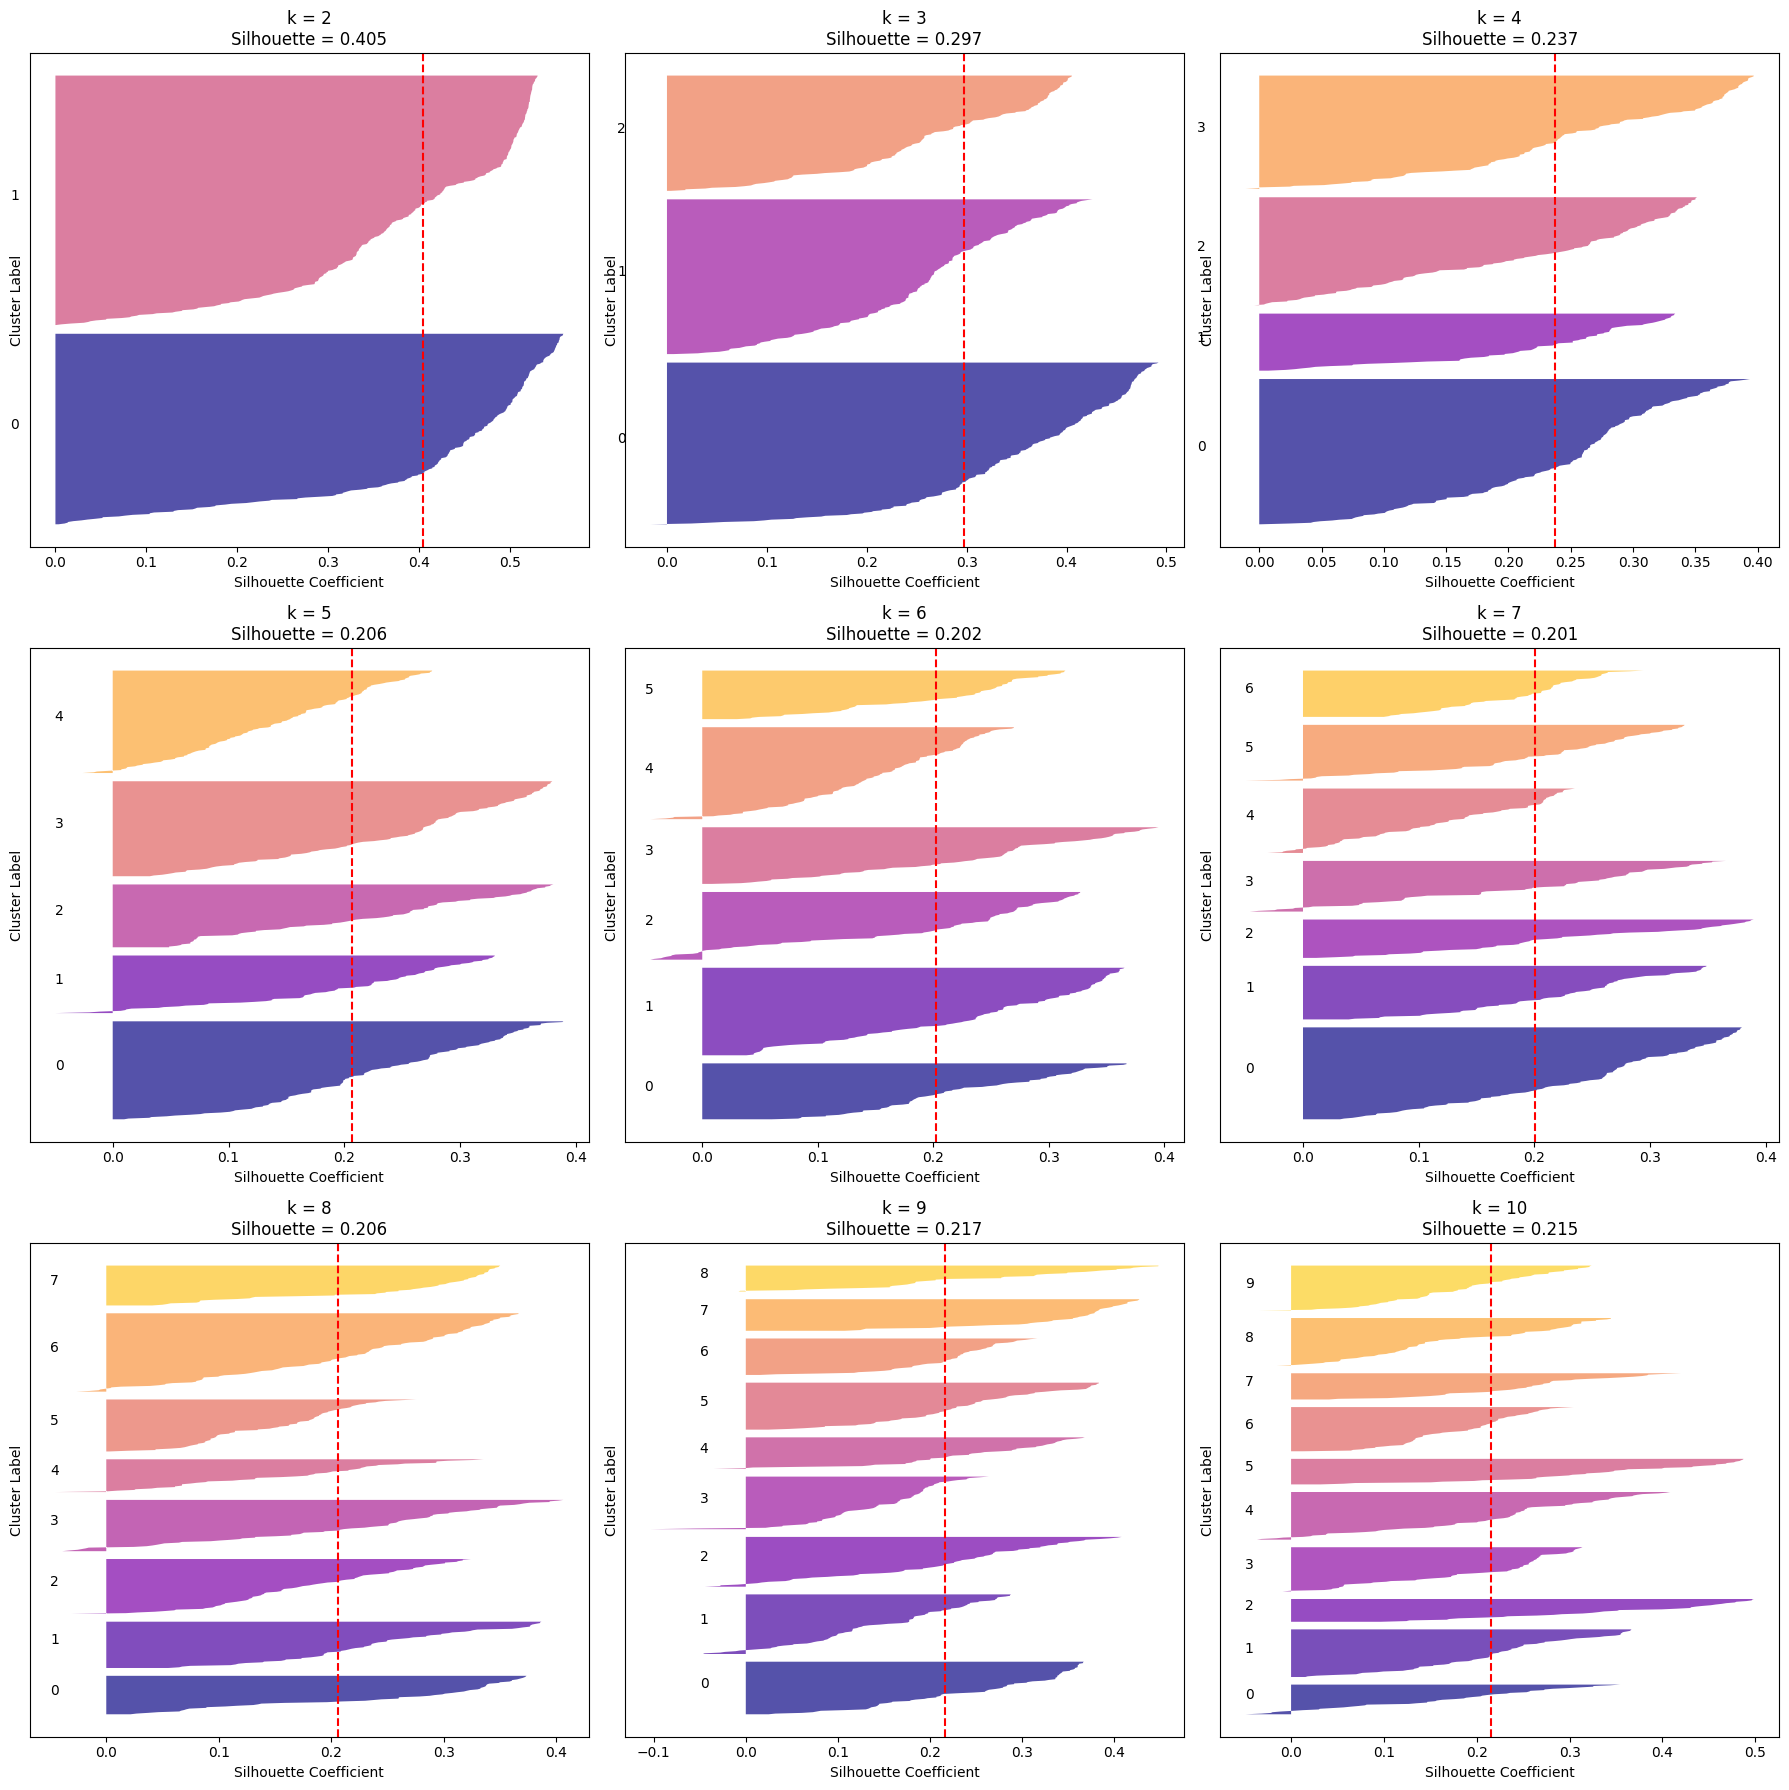

In [ ]:
# Run silhouette test on data

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    ax = axes[idx]

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_prepared)

    sample_silhouette_values = silhouette_samples(X_train_prepared, labels)
    avg_silhouette = silhouette_score(X_train_prepared, labels)

    y_lower = 10
    for cluster in range(k):
        cluster_vals = sample_silhouette_values[labels == cluster]
        cluster_vals.sort()

        size_cluster = len(cluster_vals)
        y_upper = y_lower + size_cluster

        color = plt.cm.plasma(float(cluster) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, cluster_vals,
            facecolor=color,
            alpha=0.7
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
        y_lower = y_upper + 10

    ax.axvline(x=avg_silhouette, color="red", linestyle="--")

    ax.set_title(f"k = {k}\nSilhouette = {avg_silhouette:.3f}")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.set_yticks([])

for j in range(len(k_values), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('../images/silhouette_score.png')
plt.show()

Looking at the charts above, there aren't too many bars that go below the mean value, meaning there are similarities between the data within the cluster. On each individual plot the silhouettes seem to be similar width to each other but as we get to the higher numbers we do have some negative values which indicate there may be some values that are closer to a different cluster group to the one that it has been grouped in.

Taking the silhouette score and elbow method into account it looks like two clusters will be the optimum number going forward.

In [ ]:
# Use K score to split data into clusters
best_k = 2

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_final.fit(X_train_prepared)

train_clusters = kmeans_final.predict(X_train_prepared)
test_clusters = kmeans_final.predict(X_test_prepared)

X_train_clustered = X_train.copy()
X_train_clustered['cluster'] = train_clusters

X_test_clustered = X_test.copy()
X_test_clustered['cluster'] = test_clusters

X_train_clustered.head()

,new_student_id,age,gender,relationship_status,academic_level,country,continents,most_used_platform,average_daily_usage_minutes,average_daily_use_by_hour,sleep_per_night_minutes,sleep_hours_per_night,conflicts_over_social_media,affects_academic_performance,addicted_score,mental_health_score,cluster
165,Student: 665,20,Female,Single,Undergraduate,Bangladesh,Asia,Instagram,294.0,4,384.0,6.4,3,Yes,7,5,1
543,Student: 1043,20,Female,In Relationship,Undergraduate,UAE,Asia,Instagram,414.0,6,366.0,6.1,4,Yes,8,5,1
284,Student: 784,21,Male,In Relationship,Graduate,UK,Europe,Facebook,300.0,5,396.0,6.6,3,Yes,7,6,1
361,Student: 861,20,Female,Single,Undergraduate,Ireland,Europe,TikTok,270.0,4,444.0,7.4,3,Yes,6,7,0
110,Student: 610,21,Female,In Relationship,Undergraduate,India,Asia,TikTok,348.0,5,354.0,5.9,3,Yes,7,6,1


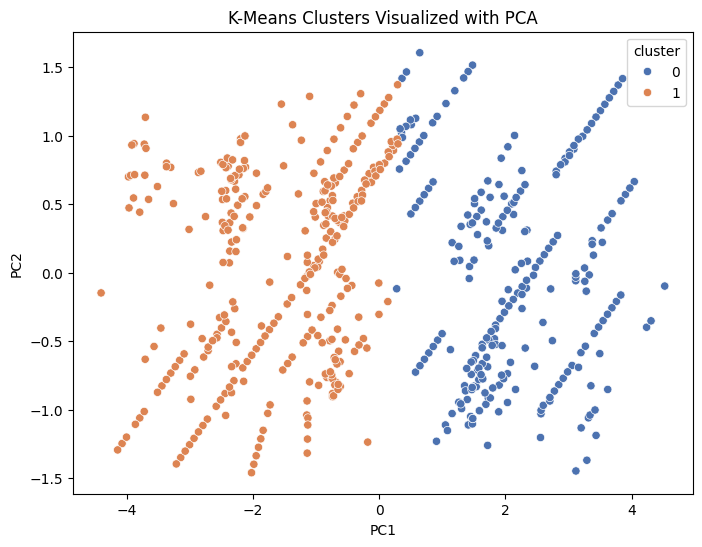

In [ ]:
# Plot clusters

pca = PCA(n_components=2)
train_pca = pca.fit_transform(X_train_prepared)

df_vis = pd.DataFrame({
    'PC1': train_pca[:, 0],
    'PC2': train_pca[:, 1],
    'cluster': train_clusters
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="cluster", palette="deep")
plt.title("K-Means Clusters Visualized with PCA")
plt.show()

In [ ]:
# Create summary statistics for each cluster

cat_features = preprocessor.named_transformers_['categorical'].get_feature_names_out(cat_cols)
all_features = list(cat_features) + num_cols

X_train_encoded_df = pd.DataFrame(X_train_prepared, columns=all_features)
X_train_encoded_df['cluster'] = train_clusters

cluster_summary = X_train_encoded_df.groupby('cluster').mean()

In [ ]:
# View summary statistics of each cluster to see patterns and trends

cluster_summary.round(2)

,gender_Male,relationship_status_In Relationship,relationship_status_Single,academic_level_High School,academic_level_Undergraduate,continents_Europe,continents_North America,continents_Rest of World,affects_academic_performance_Yes,average_daily_usage_minutes,sleep_per_night_minutes,conflicts_over_social_media,addicted_score,mental_health_score
cluster,,,,,,,,,,,,,,
0,0.52,0.47,0.51,0.01,0.5,0.59,0.05,0.10,0.15,-0.83,0.84,-0.91,-0.98,0.96
1,0.50,0.36,0.58,0.06,0.5,0.32,0.22,0.04,1.00,0.64,-0.64,0.69,0.75,-0.74
